## Perturbation of sequences
### Dataset: UniProt SARS-CoV-2 aligned w.r.t WIV04
### Number of sequences = 
### Model: VirProBERT (CoV-S-UniRef90, CoV-S-UniRef90-aligned) 

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/..']

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [3]:
human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniprot/cov-S-aligned-binary-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
perturbation_output_files = os.listdir(perturbation_processed_output_dir)
len(perturbation_output_files)

199

In [4]:
perturbed_output_dfs = []
for perturbation_output_file in perturbation_output_files:
    df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    df[pred_diff_col] = orig_pred_val - df[human_label]
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    perturbed_output_dfs.append(df)
perturbed_output_df = pd.concat(perturbed_output_dfs)

In [5]:
print(perturbed_output_df.shape)
perturbed_output_df.head()

(6316449, 9)


,Human,Non-Human,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff
0,0.980133,0.019867,A0A8B1JA98,Human,H,1836,X,0.000000,0.000000
1,0.980285,0.019715,A0A8B1JA98,Human,D,949,K,-0.000152,0.000152
2,0.980163,0.019837,A0A8B1JA98,Human,Q,1321,B,-0.000030,0.000030
3,0.980133,0.019867,A0A8B1JA98,Human,V,1423,O,0.000000,0.000000
4,0.980250,0.019750,A0A8B1JA98,Human,V,485,J,-0.000117,0.000117


### WIV04 reference sequence

In [6]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniprot/aligned/coronaviridae_s_uniprot_uniprot_metadata_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniprot_id"] == "WIV04"]
wiv04_df.head()

,uniprot_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,-----MFVFLVLLPLVS---------------------------SQ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [7]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
wiv04_aligned_seq

'-----MFVFLVLLPLVS---------------------------SQCVNLTTRTQLPP--AYTN--SFTR-----------------------------GVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNI-----IRGWIFGTTLDS----------KTQSLLIVNNAT----------N--------------VVIKVCEFQFCN-----------------------------------------------------------------DPFLGVY--------YHKNNK--------SWMESEF-RVYSS-----ANNCT-----FEYVSQP--FLMDLEGKQGNFK-------------NLREFVFK-NIDGYFKIYSKHTPINL---VRD-------------------------LPQGFS-------------------ALEPLV-----------------------------------DLPIGI--------NIT---------------------------------RFQTLLALHRSYLT-----PGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQ----PTESI---VRF-----PNITNLC----PFGEVF-------------------NATR-------------FASVYAWNRK-----------RISNCVADYSVLYNS-ASFSTFKC-----------YGVSPTKL----------------------NDLCFTNVYADSF----------VIRGD-------------------EVR-QIA----------PGQTGKI------ADYNYKLPDDFT--------G----CV----------IA-------WNSNNLDSKVGGNYNYLY---RLFRKSNL-----KPFERDISTEIYQAGST-----

In [8]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = pos
        
try:
    perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)
except: 
    pass

### Distribution of prediction difference values

/tmp/ipykernel_2497408/2860024834.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(perturbed_output_df["Human_pred_diff"])


<Figure size 432x288 with 0 Axes>

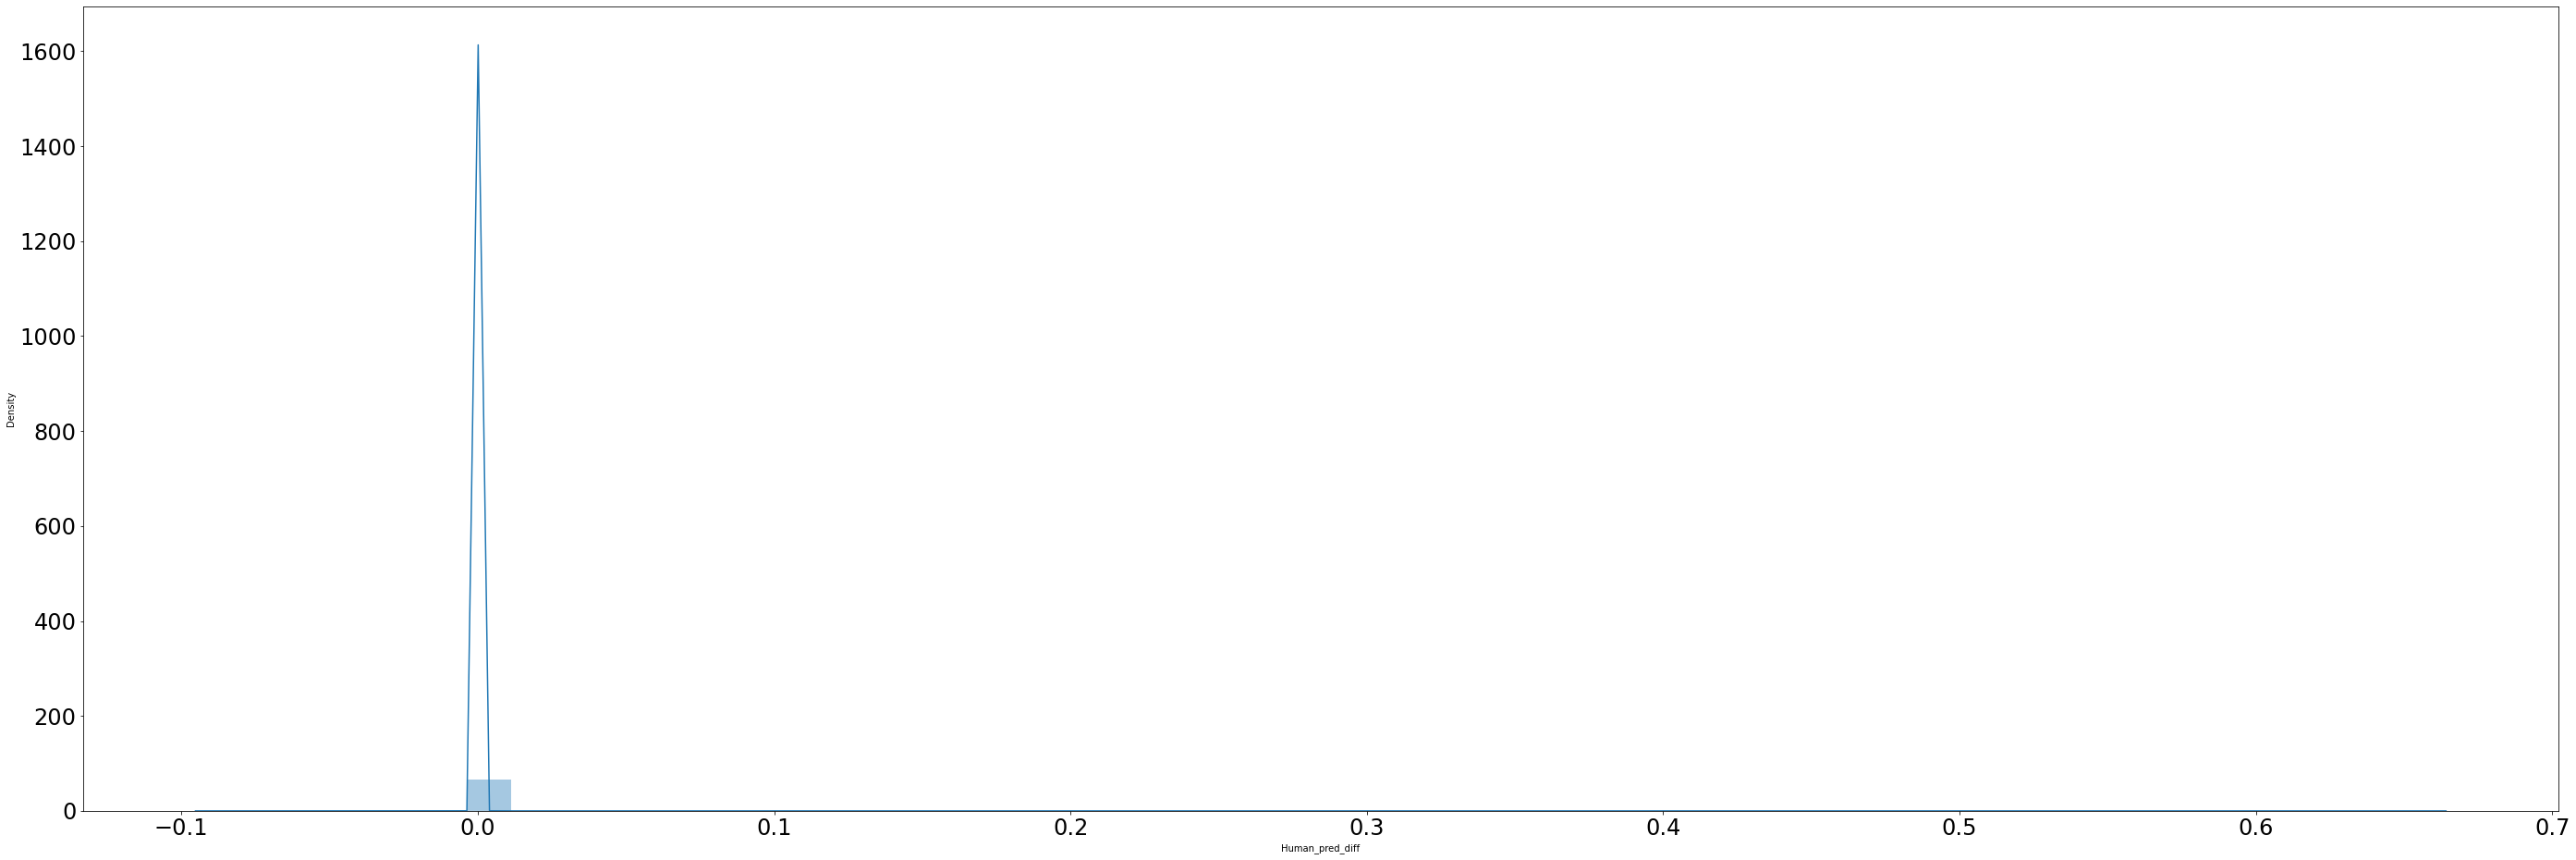

In [9]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
sns.distplot(perturbed_output_df["Human_pred_diff"])
plt.show()

In [10]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df[pred_diff_col], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})
    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.094868,-0.031649,13063,0.206809
1,-0.031649,0.031570,6303081,99.788362
2,0.031570,0.094789,195,0.003087
3,0.094789,0.158009,44,0.000697
4,0.158009,0.221228,17,0.000269
5,0.221228,0.284447,9,0.000142
6,0.284447,0.347666,1,0.000016
7,0.347666,0.410886,10,0.000158
8,0.410886,0.474105,26,0.000412
9,0.474105,0.537324,0,0.000000


In [11]:
perturbed_output_df_selected = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] > 0.1]
print(f"Number of sequences = {perturbed_output_df_selected.shape[0]}")
print(f"Number of unique positions = {len(perturbed_output_df_selected['perturb_seq_pos'].unique())}")
print(f"Unique positions = {perturbed_output_df_selected['perturb_seq_pos'].unique()}")

Number of sequences = 105
Number of unique positions = 4
Unique positions = [513. 517. 533. 502.]


In [12]:
perturbed_output_df_selected["experiment"] = "sarscov2-uniprot-aligned-binary"
perturbation_selected_output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniprot_aligned_binary.csv")
perturbed_output_df_selected.to_csv(perturbation_selected_output_file_path, index=False)

/tmp/ipykernel_2497408/3081544423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["experiment"] = "sarscov2-uniprot-aligned-binary"


### Top 10 perturbations with highest change in prediction probability

In [13]:
perturbed_output_df_selected.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)


,Human,Non-Human,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment
30290,0.304969,0.695031,A0A7U3H6A7,Human,L,1124,R,0.663762,0.663762,533.0,sarscov2-uniprot-aligned-binary
16642,0.381002,0.618998,A0A7U3DWN4,Human,L,1124,R,0.588450,0.588450,533.0,sarscov2-uniprot-aligned-binary
9696,0.396671,0.603329,A0A7U3DWM4,Human,L,1124,R,0.579047,0.579047,533.0,sarscov2-uniprot-aligned-binary
10116,0.444387,0.555613,A0A6N1WF48,Human,L,1101,R,0.440936,0.440936,517.0,sarscov2-uniprot-aligned-binary
6742,0.445686,0.554315,A0A8B1JGW7,Human,L,1101,R,0.439460,0.439460,517.0,sarscov2-uniprot-aligned-binary
13360,0.449469,0.550531,A0A8B1JBB1,Human,L,1101,R,0.435902,0.435902,517.0,sarscov2-uniprot-aligned-binary
31760,0.449469,0.550531,A0A7T7P276,Human,L,1101,R,0.435902,0.435902,517.0,sarscov2-uniprot-aligned-binary
31324,0.452878,0.547122,A0A8B6RB96,Human,L,1101,R,0.432568,0.432568,517.0,sarscov2-uniprot-aligned-binary
28153,0.454781,0.545219,A0A6M3HLG5,Human,L,1101,R,0.430470,0.430470,517.0,sarscov2-uniprot-aligned-binary
13461,0.456388,0.543612,A0A8B1J7Y2,Human,L,1101,R,0.428968,0.428968,517.0,sarscov2-uniprot-aligned-binary


In [14]:
perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)
perturbed_output_df_selected.head()

/tmp/ipykernel_2497408/2825421286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)


,Human,Non-Human,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment,perturbation_id
10176,0.745694,0.254306,A0A7U0MMV8,Human,L,1097,R,0.140228,0.140228,513.0,sarscov2-uniprot-aligned-binary,513.0_R
26230,0.479659,0.520341,A0A7U0MMV8,Human,L,1101,R,0.406263,0.406263,517.0,sarscov2-uniprot-aligned-binary,517.0_R
21163,0.756153,0.243847,A0A7U3EDI5,Human,L,1124,R,0.223293,0.223293,533.0,sarscov2-uniprot-aligned-binary,533.0_R
3403,0.576479,0.423521,A0A7U3DWG5,Human,L,1124,R,0.402482,0.402482,533.0,sarscov2-uniprot-aligned-binary,533.0_R
4320,0.818276,0.181724,A0A7U3DWG5,Human,L,1124,W,0.160685,0.160685,533.0,sarscov2-uniprot-aligned-binary,533.0_W


In [15]:
mean_diff_df = perturbed_output_df_selected[["perturbation_id", "abs_Human_pred_diff"]].groupby("perturbation_id").mean(pred_diff_col)

In [16]:
mean_diff_df = mean_diff_df.reset_index()

In [17]:
mean_diff_df[["perturb_seq_pos", "new_token"]] = mean_diff_df["perturbation_id"].str.split("_", expand=True)

In [18]:
mean_diff_df.head()

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
0,502.0_D,0.101086,502.0,D
1,513.0_R,0.143218,513.0,R
2,517.0_R,0.419025,517.0,R
3,533.0_A,0.213219,533.0,A
4,533.0_B,0.213386,533.0,B


In [19]:
mean_diff_df[mean_diff_df[["perturb_seq_pos", "new_token"]].duplicated()]

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token


In [20]:
df = mean_diff_df.pivot(columns="perturb_seq_pos", index="new_token", values="abs_Human_pred_diff")
# df[token_positions]

In [21]:
mean_diff_df.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
19,533.0_R,0.476093,533.0,R
2,517.0_R,0.419025,517.0,R
9,533.0_G,0.230991,533.0,G
17,533.0_P,0.227721,533.0,P
18,533.0_Q,0.227248,533.0,Q
25,533.0_X,0.227207,533.0,X
26,533.0_Y,0.224234,533.0,Y
10,533.0_H,0.221997,533.0,H
20,533.0_S,0.218614,533.0,S
7,533.0_E,0.218368,533.0,E


<Figure size 432x288 with 0 Axes>

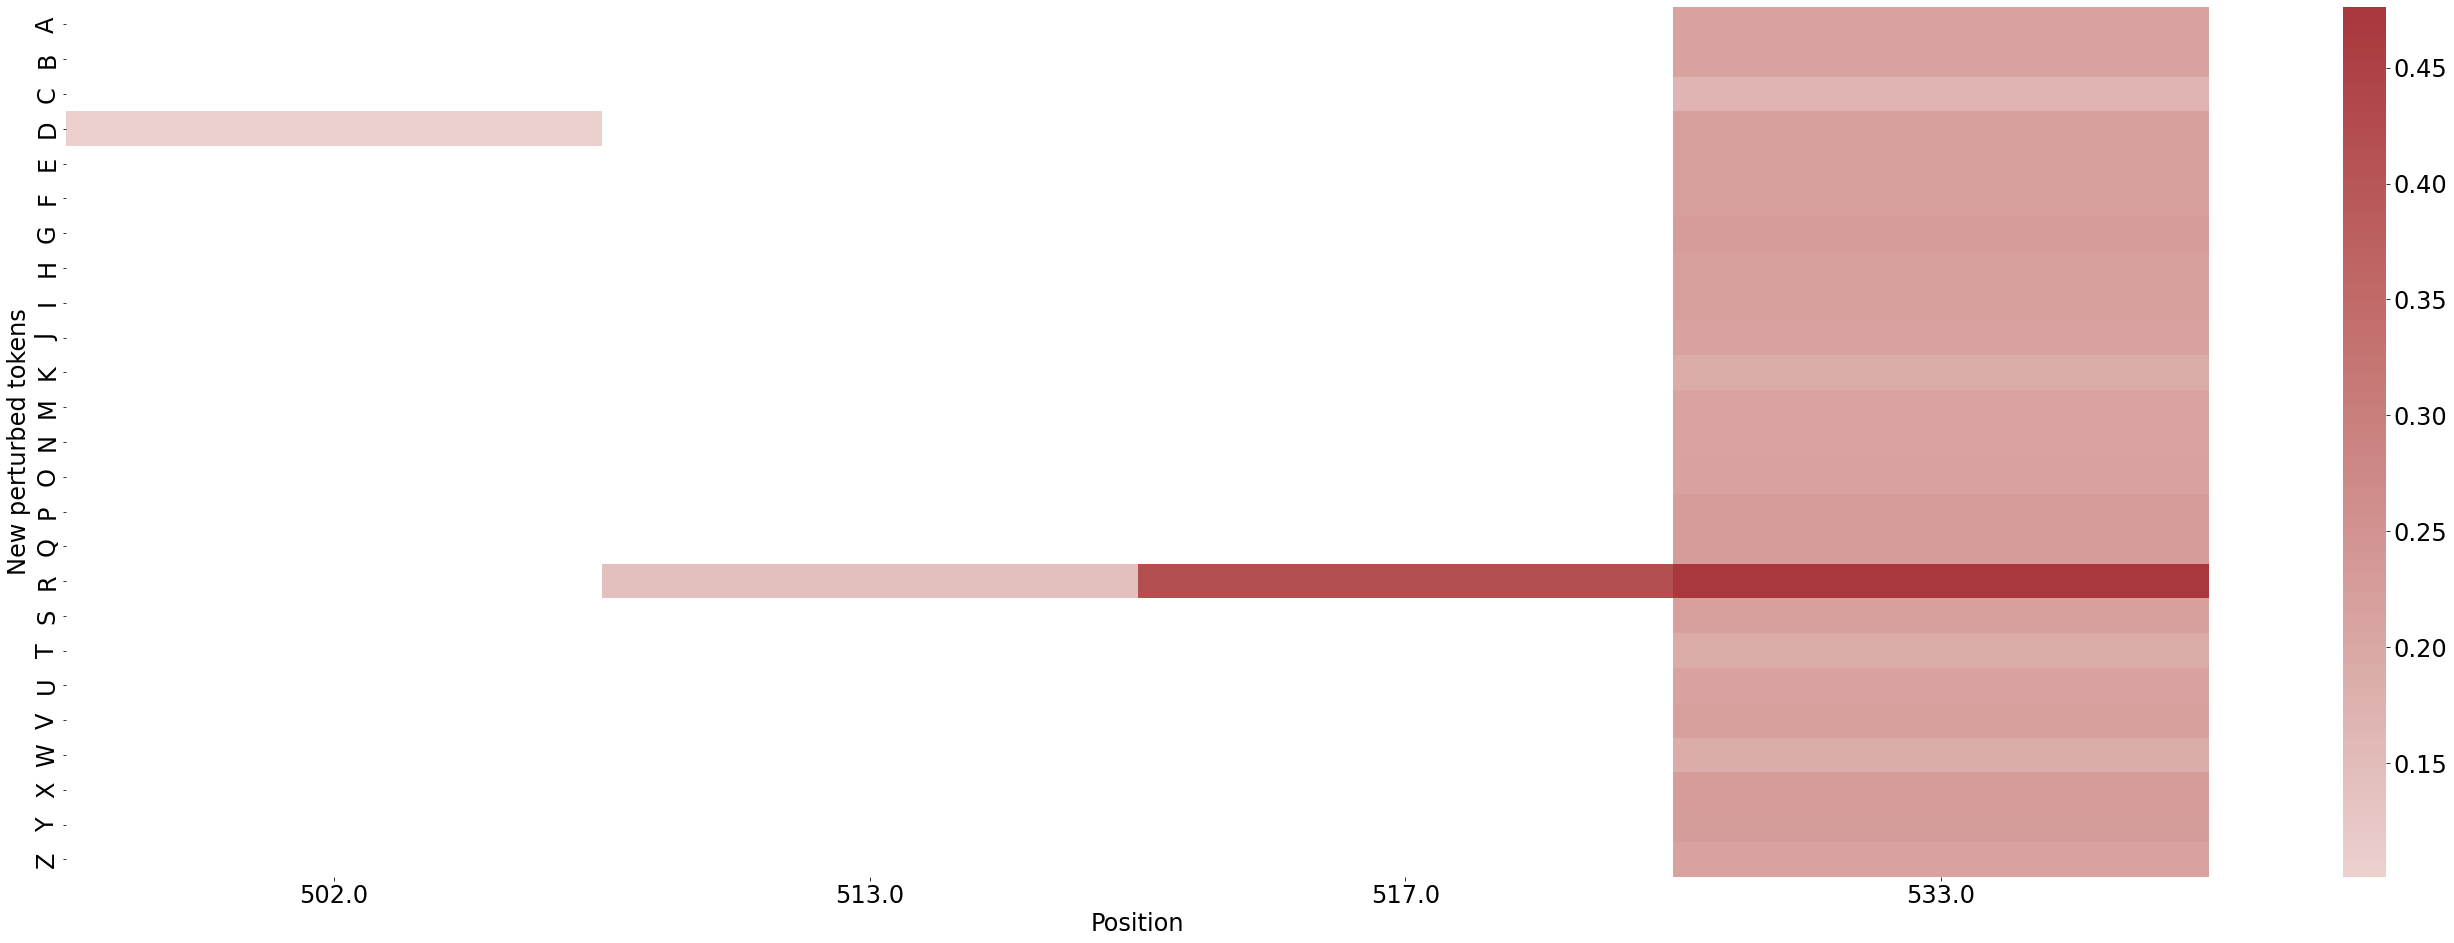

In [22]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
# plt.rcParams['figure.autolayout'] = True
ax = sns.heatmap(df, cmap=cmap, center=0)
plt.xlabel('Position', fontsize=24)
plt.ylabel('New perturbed tokens', fontsize=24)
plt.show()

In [23]:
df.mean(axis=0)

perturb_seq_pos
502.0    0.101086
513.0    0.143218
517.0    0.419025
533.0    0.223089
dtype: float64

<Figure size 432x288 with 0 Axes>

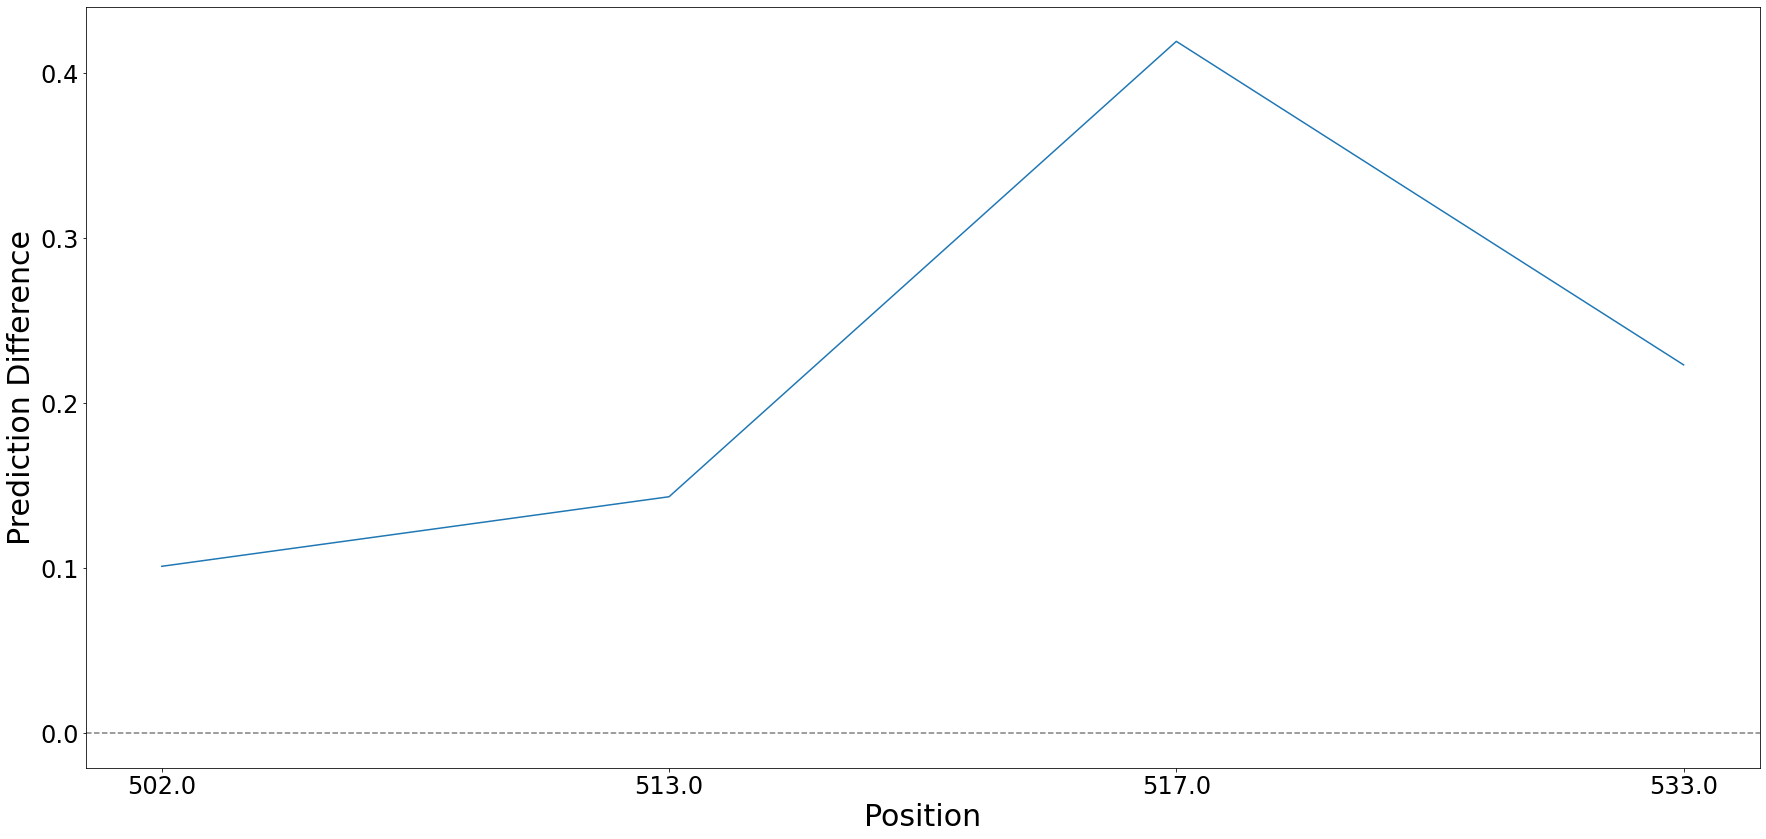

In [24]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
ax.axhline(0.0, color="gray", linestyle="--")
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.xlabel('Position', fontsize=30)
plt.ylabel('Prediction Difference', fontsize=30)
#ax.set_xlim(0, 1273)
plt.show()